# Learning to optimize parametric Quadratic Programming (pQP) and  Quadratically Constrained QP (pQCQP) problems using Neuromancer.


This is an interactive notebook based on the python script [Part_2_LearnToOptimize_pQP.py](./Part_2_LearnToOptimize_pQP.py).  

Problem formulation pQP:
$$
    \begin{align}
    &\text{minimize } &&   x^2 + y^2\\
    &\text{subject to} &&  -x - y + p1 \le 0\\
    &  &&    x + y - p1 - 5 \le 0\\
    &  &&    x - y + p2 - 5 \le 0\\
    &  &&   -x + y - p2  \le 0\\
    \end{align}
$$


Problem formulation pQCQP:
$$
    \begin{align}
    &\text{minimize } &&   x^2 + y^2\\
    &\text{subject to} &&  -x - y + p1 \le 0\\
    &  &&     x^2 + y^2 \le p2^2\\
    \end{align}
$$

with parameters $p, a$ and decision variables $x, y$.

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [1]:
!pip install neuromancer

  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1


*Note: When running on Colab, one might encounter a pip dependency error with Lida 0.0.10. This can be ignored*

### Import

In [1]:
import cvxpy as cp
import numpy as np
import time
import torch
import torch.nn as nn
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

In [2]:
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node

# Dataset

In [3]:
data_seed = 408  # random seed used for simulated data
np.random.seed(data_seed)
torch.manual_seed(data_seed)

In [4]:
# select from 'pQP' or 'pQCQP'
problem_type = 'pQP'   

Randomly sample parameters from a uniform distribution: $0.5\le p\le2.0$;  $0.2\le a\le1.2$

In [5]:
nsim = 3000  # number of datapoints: increase sample density for more robust results
# create dictionaries with sampled datapoints with uniform distribution
p_low, p_high = 1.0, 11.0
samples_train = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                 "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_dev = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
               "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_test = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
               "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0,
                                           collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=32, num_workers=0,
                                         collate_fn=dev_data.collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0,
                                         collate_fn=test_data.collate_fn, shuffle=True)
# note: training quality will depend on the DataLoader parameters such as batch size and shuffle

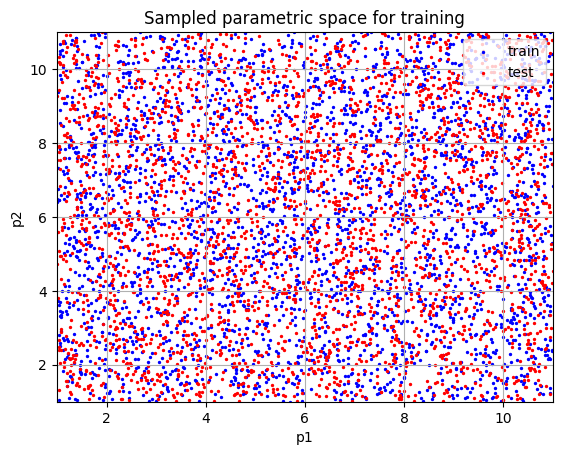

In [6]:
# visualize taining and test samples for 2D parametric space
a_train = samples_train['p1'].numpy()
p_train = samples_train['p2'].numpy()
a_dev = samples_dev['p1'].numpy()
p_dev = samples_dev['p2'].numpy()
plt.figure()
plt.scatter(a_train, p_train, s=2., c='blue', marker='o')
plt.scatter(a_dev, p_dev, s=2., c='red', marker='o')
plt.title('Sampled parametric space for training')
plt.xlim(p_low, p_high)
plt.ylim(p_low, p_high)
plt.grid(True)
plt.xlabel('p1')
plt.ylabel('p2')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.show(block=True)

# pQP Formulation in NeuroMANCER

## Primal Solution Map Architecture

In [7]:
# define neural architecture for the solution map
func = blocks.MLP(insize=2, outsize=2,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes=[80] * 4)
# wrap neural net into symbolic representation of the solution map via the Node class: sol_map(xi) -> x
sol_map = Node(func, ['p1', 'p2'], ['x'], name='map')
# trainable components of the problem solution
components = [sol_map]

## Objective and Constraints in NeuroMANCER

In [8]:
"""
variable is a basic symbolic abstraction in Neuromancer
   x = variable("variable_name")                      (instantiates new variable)  
variable construction supports:
   algebraic expressions:     x**2 + x**3 + 5     (instantiates new variable)  
   slicing:                   x[:, i]             (instantiates new variable)  
   pytorch callables:         torch.sin(x)        (instantiates new variable)  
   constraints definition:    x <= 1.0            (instantiates Constraint object) 
   objective definition:      x.minimize()        (instantiates Objective object) 
to visualize computational graph of the variable use x.show() method          
"""

# variables
x = variable("x")[:, [0]]
y = variable("x")[:, [1]]
# sampled parameters
p1 = variable('p1')
p2 = variable('p2')

# objective function
f = x ** 2 + y ** 2
obj = f.minimize(weight=1.0, name='obj')
objectives = [obj]

# constraints
Q_con = 100.
g1 = -x - y + p1
con_1 = Q_con * (g1 <= 0)
con_1.name = 'c1'
if problem_type == 'pQP':  # constraints for QP
    g2 = x + y - p1 - 5
    con_2 = Q_con*(g2 <= 0)
    con_2.name = 'c2'
    g3 = x - y + p2 - 5
    con_3 = Q_con*(g3 <= 0)
    con_3.name = 'c3'
    g4 = -x + y - p2
    con_4 = Q_con*(g4 <= 0)
    con_4.name = 'c4'
    constraints = [con_1, con_2, con_3, con_4]
elif problem_type == 'pQCQP':  # constraints for QCQP
    g2 = x**2+y**2 - p2**2
    con_2 = Q_con*(g2 <= 0)
    con_2.name = 'c2'
    constraints = [con_1, con_2]

In [9]:
# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)

## Parametric Problem Solution in NeuroMANCER

In [10]:
lr = 0.001      # step size for gradient descent
epochs = 400    # number of training epochs
warmup = 100    # number of epochs to wait before enacting early stopping policy
patience = 100  # number of epochs with no improvement in eval metric to allow before early stopping

In [11]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)

# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=epochs,
    patience=patience,
    warmup=warmup)

In [12]:
# Train NLP solution map
best_model = trainer.train()
best_outputs = trainer.test(best_model)
# load best model dict
problem.load_state_dict(best_model)

epoch: 0  train_loss: 122.0165786743164
epoch: 1  train_loss: 32.59976577758789
epoch: 2  train_loss: 32.42778778076172
epoch: 3  train_loss: 31.820749282836914
epoch: 4  train_loss: 34.016841888427734
epoch: 5  train_loss: 32.415164947509766
epoch: 6  train_loss: 34.889774322509766
epoch: 7  train_loss: 32.637351989746094
epoch: 8  train_loss: 31.90712547302246
epoch: 9  train_loss: 32.11321258544922
epoch: 10  train_loss: 31.718921661376953
epoch: 11  train_loss: 30.254234313964844
epoch: 12  train_loss: 30.69602394104004
epoch: 13  train_loss: 30.477611541748047
epoch: 14  train_loss: 29.67075538635254
epoch: 15  train_loss: 30.36856460571289
epoch: 16  train_loss: 30.05189323425293
epoch: 17  train_loss: 29.986268997192383
epoch: 18  train_loss: 31.145029067993164
epoch: 19  train_loss: 31.928056716918945
epoch: 20  train_loss: 29.9550838470459
epoch: 21  train_loss: 29.84864616394043
epoch: 22  train_loss: 30.215057373046875
epoch: 23  train_loss: 28.873130798339844
epoch: 24  tra

<All keys matched successfully>

## Get a QP solution from CVXPY as a benchmark

[CVXPY](https://www.cvxpy.org/) is an open-source tool for constrained optimization that has influenced the development of NeuroMANCER.

In [13]:
# Define the CVXPY problems.
def QP_param(p1, p2):
    x = cp.Variable(1)
    y = cp.Variable(1)
    prob = cp.Problem(cp.Minimize(x ** 2 + y ** 2),
                      [-x - y + p1 <= 0,
                       x + y - p1 - 5 <= 0,
                       x - y + p2 - 5 <= 0,
                       -x + y - p2 <= 0])
    return prob, x, y

def QCQP_param(p1, p2):
    x = cp.Variable(1)
    y = cp.Variable(1)
    prob = cp.Problem(cp.Minimize(x ** 2 + y ** 2),
                  [-x - y + p1 <= 0,
                   x ** 2 + y ** 2 - p2 ** 2 <= 0])
    return prob, x, y

## Compare: NeuroMANCER vs. CVXPY

primal solution pQP x=[1.], y=[1.]
parameter p=(2.0, 2.0)
primal solution Neuromancer x1=1.2035504579544067, x2=0.8227365612983704
 f: tensor([[2.1254]], grad_fn=<AddBackward0>)
 g1: tensor([[-0.0263]], grad_fn=<AddBackward0>)
 g2: tensor([[-4.9737]], grad_fn=<SubBackward0>)
 g3: tensor([[-2.6192]], grad_fn=<SubBackward0>)
 g4: tensor([[-2.3808]], grad_fn=<SubBackward0>)


C:\Users\drgon\AppData\Local\Temp\ipykernel_59452\2728073885.py:30: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  plt.setp(cg1.collections,
C:\Users\drgon\AppData\Local\Temp\ipykernel_59452\2728073885.py:32: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  plt.setp(cg2.collections,
C:\Users\drgon\AppData\Local\Temp\ipykernel_59452\2728073885.py:34: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  plt.setp(cg3.collections,
C:\Users\drgon\AppData\Local\Temp\ipykernel_59452\2728073885.py:36: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  plt.setp(cg4.collections,


primal solution pQP x=[1.5], y=[1.5]
parameter p=(3.0, 3.0)
primal solution Neuromancer x1=1.6041899919509888, x2=1.3785439729690552
 f: tensor([[4.4738]], grad_fn=<AddBackward0>)
 g1: tensor([[0.0173]], grad_fn=<AddBackward0>)
 g2: tensor([[-5.0173]], grad_fn=<SubBackward0>)
 g3: tensor([[-1.7744]], grad_fn=<SubBackward0>)
 g4: tensor([[-3.2256]], grad_fn=<SubBackward0>)
primal solution pQP x=[2.], y=[2.]
parameter p=(4.0, 4.0)
primal solution Neuromancer x1=1.9988573789596558, x2=2.0022976398468018
 f: tensor([[8.0046]], grad_fn=<AddBackward0>)
 g1: tensor([[-0.0012]], grad_fn=<AddBackward0>)
 g2: tensor([[-4.9988]], grad_fn=<SubBackward0>)
 g3: tensor([[-1.0034]], grad_fn=<SubBackward0>)
 g4: tensor([[-3.9966]], grad_fn=<SubBackward0>)
primal solution pQP x=[2.5], y=[2.5]
parameter p=(5.0, 5.0)
primal solution Neuromancer x1=2.2224645614624023, x2=2.778649091720581
 f: tensor([[12.6602]], grad_fn=<AddBackward0>)
 g1: tensor([[-0.0011]], grad_fn=<AddBackward0>)
 g2: tensor([[-4.9989]

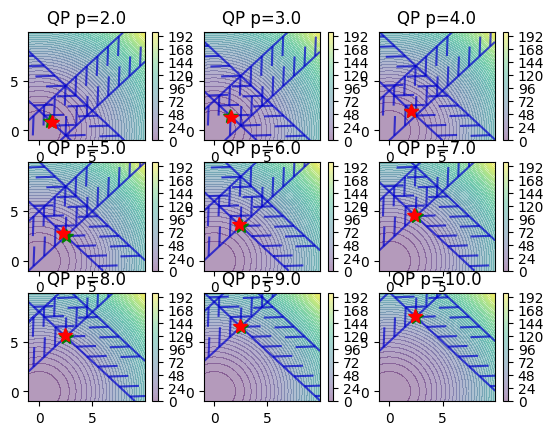

In [14]:
"""
Plots
"""
# test problem parameters
params = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
x1 = np.arange(-1.0, 10.0, 0.05)
y1 = np.arange(-1.0, 10.0, 0.05)
xx, yy = np.meshgrid(x1, y1)
fig, ax = plt.subplots(3,3)
row_id = 0
column_id = 0
for i, p in enumerate(params):
    if i % 3 == 0 and i != 0:
        row_id += 1
        column_id = 0

    # eval and plot objective and constraints
    J = xx ** 2 + yy ** 2
    cp_plot = ax[row_id, column_id].contourf(xx, yy, J, 50, alpha=0.4)
    ax[row_id, column_id].set_title(f'QP p={p}')
    if problem_type == 'pQP':  # constraints for QP
        c1 = xx + yy - p
        c2 = -xx - yy + p + 5
        c3 = -xx + yy - p + 5
        c4 = xx - yy + p
        cg1 = ax[row_id, column_id].contour(xx, yy, c1, [0], colors='mediumblue', alpha=0.7)
        cg2 = ax[row_id, column_id].contour(xx, yy, c2, [0], colors='mediumblue', alpha=0.7)
        cg3 = ax[row_id, column_id].contour(xx, yy, c3, [0], colors='mediumblue', alpha=0.7)
        cg4 = ax[row_id, column_id].contour(xx, yy, c4, [0], colors='mediumblue', alpha=0.7)

        if hasattr(cg1, 'collections') and cg1.collections:
            plt.setp(cg1.collections,
                     path_effects=[patheffects.withTickedStroke()], alpha=0.7)
            plt.setp(cg2.collections,
                     path_effects=[patheffects.withTickedStroke()], alpha=0.7)
            plt.setp(cg3.collections,
                     path_effects=[patheffects.withTickedStroke()], alpha=0.7)
            plt.setp(cg4.collections,
                     path_effects=[patheffects.withTickedStroke()], alpha=0.7)

    if problem_type == 'pQCQP':  # constraints for QCQP
        c1 = xx + yy - p
        c2 = - xx**2 - yy**2 + p**2
        cg1 = ax[row_id, column_id].contour(xx, yy, c1, [0], colors='mediumblue', alpha=0.7)
        cg2 = ax[row_id, column_id].contour(xx, yy, c2, [0], colors='mediumblue', alpha=0.7)
        if hasattr(cg1, 'collections') and cg1.collections:
            plt.setp(cg1.collections,
                     path_effects=[patheffects.withTickedStroke()], alpha=0.7)
            plt.setp(cg2.collections,
                     path_effects=[patheffects.withTickedStroke()], alpha=0.7)
    fig.colorbar(cp_plot, ax=ax[row_id,column_id])

    # Solve CVXPY problem
    if problem_type == 'pQP':
        prob, x, y = QP_param(p, p)
    elif problem_type == 'pQCQP':
        prob, x, y = QCQP_param(p, p)
    prob.solve()

    # Solve via neuromancer
    datapoint = {'p1': torch.tensor([[p]]), 'p2': torch.tensor([[p]]),
                 'name': 'test'}
    model_out = problem(datapoint)
    x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
    y_nm = model_out['test_' + "x"][0, 1].detach().numpy()

    print(f'primal solution {problem_type} x={x.value}, y={y.value}')
    print(f'parameter p={p, p}')
    print(f'primal solution Neuromancer x1={x_nm}, x2={y_nm}')
    print(f' f: {model_out["test_" + f.key]}')
    print(f' g1: {model_out["test_" + g1.key]}')
    print(f' g2: {model_out["test_" + g2.key]}')
    if problem_type == 'pQP':
        print(f' g3: {model_out["test_" + g3.key]}')
        print(f' g4: {model_out["test_" + g4.key]}')

    # Plot optimal solutions
    ax[row_id, column_id].plot(x.value, y.value, 'g*', markersize=10)
    ax[row_id, column_id].plot(x_nm, y_nm, 'r*', markersize=10)
    column_id += 1
plt.show()
plt.show(block=True)
plt.interactive(False)

In [16]:
"""
Benchmark Solution
"""

def eval_constraints(x, y, p1, p2):
    """
    evaluate mean constraints violations
    """
    con_1_viol = np.maximum(0, -x - y + p1)
    con_2_viol = np.maximum(0, x + y - p1 - 5)
    con_3_viol = np.maximum(0, x - y + p2 - 5)
    con_4_viol = np.maximum(0, -x + y - p2)
    con_viol = con_1_viol + con_2_viol + con_3_viol + con_4_viol
    con_viol_mean = np.mean(con_viol)
    return con_viol_mean

def eval_objective(x, y, a1=1, a2=1):
    obj_value_mean = np.mean(a1 * x**2 + a2 * y**2)
    return obj_value_mean

# Solve via neuromancer
t = time.time()
samples_test['name'] = 'test'
model_out = problem(samples_test)
nm_time = time.time() - t
x_nm = model_out['test_' + "x"][:, [0]].detach().numpy()
y_nm = model_out['test_' + "x"][:, [1]].detach().numpy()

# Solve via solver
t = time.time()
x_solver, y_solver = [], []
P1, P2 = [], []
for i in range(0, nsim):
    p1 = samples_test['p1'][i].detach().numpy()
    p2 = samples_test['p2'][i].detach().numpy()
    prob, x, y = QP_param(p1, p2)
    prob.solve(solver='OSQP', verbose=False)
    prob.solve()
    x_solver.append(x.value)
    y_solver.append(y.value)
    P1.append(p1)
    P2.append(p2)
solver_time = time.time() - t
x_solver = np.asarray(x_solver)
y_solver = np.asarray(y_solver)
P1 = np.asarray(P1)
P2 = np.asarray(P2)

# Evaluate neuromancer solution
print(f'Solution for {nsim} problems via Neuromancer obtained in {nm_time:.4f} seconds')
nm_con_viol_mean = eval_constraints(x_nm, y_nm, P1, P2)
print(f'Neuromancer mean constraints violation {nm_con_viol_mean:.4f}')
nm_obj_mean = eval_objective(x_nm, y_nm)
print(f'Neuromancer mean objective value {nm_obj_mean:.4f}')

# Evaluate solver solution
print(f'Solution for {nsim} problems via solver obtained in {solver_time:.4f} seconds')
solver_con_viol_mean = eval_constraints(x_solver, y_solver, P1, P2)
print(f'Solver mean constraints violation {solver_con_viol_mean:.4f}')
solver_obj_mean = eval_objective(x_solver, y_solver)
print(f'Solver mean objective value {solver_obj_mean:.4f}')

# neuromancer solver comparison
speedup_factor = solver_time/nm_time
print(f'Solution speedup factor {speedup_factor:.4f}')

# Difference in primal optimizers
dx = (x_solver - x_nm)[:,0]
dy = (y_solver - y_nm)[:,0]
err_x = np.mean(dx**2)
err_y = np.mean(dy**2)
err_primal = err_x + err_y
print('MSE primal optimizers:', err_primal)

# Difference in objective
err_obj = np.abs(solver_obj_mean - nm_obj_mean) / solver_obj_mean * 100
print(f'mean objective value discrepancy: {err_obj:.2f} %')

# stats to log
stats = {"nsim": nsim,
         "nm_time": nm_time,
         "nm_con_viol_mean": nm_con_viol_mean,
         "nm_obj_mean": nm_obj_mean,
         "solver_time": solver_time,
         "solver_con_viol_mean": solver_con_viol_mean,
         "solver_obj_mean": solver_obj_mean,
         "speedup_factor": speedup_factor,
         "err_primal": err_primal,
         "err_obj": err_obj}

Solution for 3000 problems via Neuromancer obtained in 0.0157 seconds
Neuromancer mean constraints violation 0.0210
Neuromancer mean objective value 26.5845
Solution for 3000 problems via solver obtained in 50.2921 seconds
Solver mean constraints violation 0.0000
Solver mean objective value 26.2859
Solution speedup factor 3197.8071
MSE primal optimizers: 0.031133980584664066
mean objective value discrepancy: 1.14 %
